# 03A - Manual Baseline

In [7]:
from surprise import Dataset, evaluate, SVD, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [8]:
data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

In [9]:
def bias_baseline(in_df, in_tests):
    
    # accumulate a new rmse on each test
    mae_list = list()
    
    for i in range(in_tests):
        
        shuffled_df = in_df.sample(frac=1, random_state=i)
        split_index = int(shuffled_df.shape[0] * 0.8)
        train_df = shuffled_df.iloc[0:split_index, :]
        test_df = shuffled_df.iloc[split_index:, :]
        
        overall_mean = train_df['overall'].mean()
        
        #calculate item biases (overall_mean - item_mean)
        item_means = train_df.groupby('asin').mean()
        item_biases = item_means['overall'] - overall_mean
        
        #calculate user biases (overall_mean - user_mean)
        user_means = train_df.groupby('reviewerID').mean()
        user_biases = user_means['overall'] - overall_mean
        
        #apply below function to each row in test_df
        def calc_abs_error(row):
            asin = row['asin']
            reviewerID = row['reviewerID']
            rating_actual = row['overall']
            
            user_bias = user_biases[reviewerID]
            item_bias = item_biases[asin]
            
            rating_predicted = overall_mean + user_bias + item_bias
            abs_error = abs(rating_predicted - rating_actual)
            return abs_error
        
        #for each element in 'test', calculuate the squared error 
        errors = test_df.apply(func = calc_abs_error, axis = 1)
        
        #calculate rmse and append
        mae = errors.mean()
        mae_list.append(mae)
        
    return np.array(mae_list)

In [10]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_baseline_man.array'), 'rb') as file_in:
        mae_list = pkl.load(file_in)
else:
    mae_list = bias_baseline(df_100, in_tests = 5)
    with open(os.path.join(data_path, 'results_baseline_man.array'), 'wb') as file_out:
          pkl.dump(mae_list, file_out)
        
print(mae_list)

[ 0.756029    0.75479449  0.75552996  0.75543144  0.75329674]


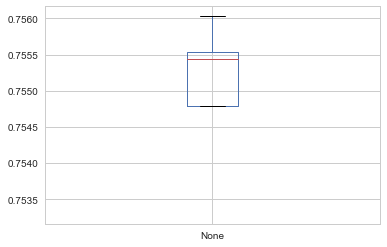

In [11]:
pd.Series(mae_list).plot(kind = 'box')

# Runtimes

In [14]:
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = False

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_baseline_manual.list'), 'rb') as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:

        start = time.time()
        bias_baseline(df_100, in_tests = 1)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_baseline_manual.list'), 'wb') as file_out:
        pkl.dump(runtime_list, file_out)

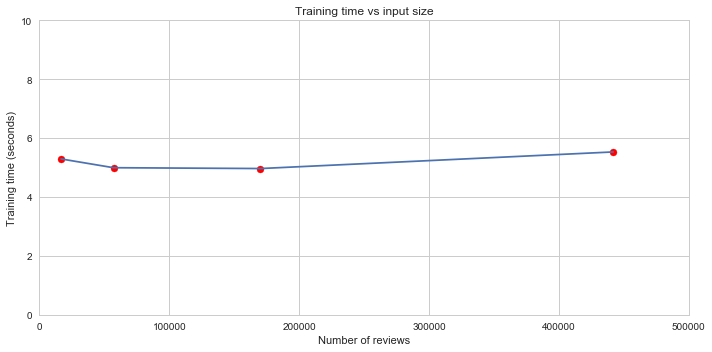

In [17]:
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 10)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()